In [ ]:
# analysis of meshplots
# O-F for all experiments, read the pkl files generated from
# /scratch2/GFDL/gfdlscr/Chih-Chi.Hu/gsidiag/ush/cnvstats/grid_cnv_stats.py

In [6]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy
print(cartopy.__version__)

0.21.1


In [7]:
pkl_dir = '/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/gsidiag/ush/cnvstats/data/mesh_pkl/'
#obs_var = 't'
#obs_var_long_name = 'Temperature'
obs_var = 'q'
obs_var_long_name = 'Humidity'
#obs_var = 'gps'
#obs_var_long_name = 'GPSRO'

time    = '2022061500_2022081000'
#expids  = ['full_CTRL', 'full_CTRL_noinf', 'full_only_clr', 'full_ctrl', 'full_clr_cld']
#expids  = ['full_CTRL', 'full_CTRL_noinf', 'full_only_clr', 'full_clr_cld', 'full_sym_tri_clwnbc']
#expids = ['full_CTRL', 'full_CTRL_noinf']
#expids  = ['full_CTRL', 'full_only_clr', 'full_clr_cld']
expids = ['full_CTRL']


expid_short = {'full_clr_cld':    'CLR-CLD',
               'full_CTRL':       'CTRL',
               'full_CTRL_noinf': 'NOINF',
               'full_only_clr':   'CLR',
               'full_ctrl':       'all',
               'full_obs':        'obs cld',
               'full_model':      'model cld',
               'full_sym':        'sym cld',
               'full_obs_clwnbc':   'obs cld (no BC)',
               'full_model_clwnbc': 'model cld (no BC)',
               'full_sym_clwnbc':   'sym cld (no BC)',
               'full_sym_tri_clwnbc': 'sym cld'}

In [8]:
meshinfo = {};

for exp in expids:
    #with open(f'{pkl_dir}/{exp}/{obs_var}_{exp}_{time}.pkl', 'rb') as f:
    with open(f'{pkl_dir}/{exp}/{obs_var}_{exp}_{time}_only_land.pkl', 'rb') as f:
        meshinfo[exp] = pickle.load(f)


In [9]:
# vertical layers definitions
#ptop=np.array([1000.,900.,800.,600.,400.,300.,250.,200.,150.,100.,50.,30.,20.,10.,5.,0.])
#pbot=np.array([1200.,1000.,900.,800.,600.,400.,300.,250.,200.,150.,100.,50.,30.,20.,10.,5.])

ptop=np.array([850., 1000.,900.,800.,600.,400.,300.,250.,200.,150.,100.,50.,30.,20.,10.,5.,0.])
pbot=np.array([1200., 1200.,1000.,900.,800.,600.,400.,300.,250.,200.,150.,100.,50.,30.,20.,10.,5.])

ptopgps=np.array([1000.,900.,800.,600.,400.,300.,250.,200.,150.,100.,50.,30.,20.,10.,7.,5.,3.,2.,1.,0.])
pbotgps=np.array([1200.,1000.,900.,800.,600.,400.,300.,250.,200.,150.,100.,50.,30.,20.,10.,7.,5.,3.,2.,1.])

#ptopq=np.array([1000.,950.,900.,850.,800.,700.,600.,500.,400.,300.,200.,100.])
#pbotq=np.array([1200.,1000.,950.,900.,850.,800.,700.,600.,500.,400.,300.,200.])

ptopq=np.array([850., 1000.,950.,900.,850.,800.,700.,600.,500.,400.,300.,200.,100.])
pbotq=np.array([1200., 1200.,1000.,950.,900.,850.,800.,700.,600.,500.,400.,300.,200.])

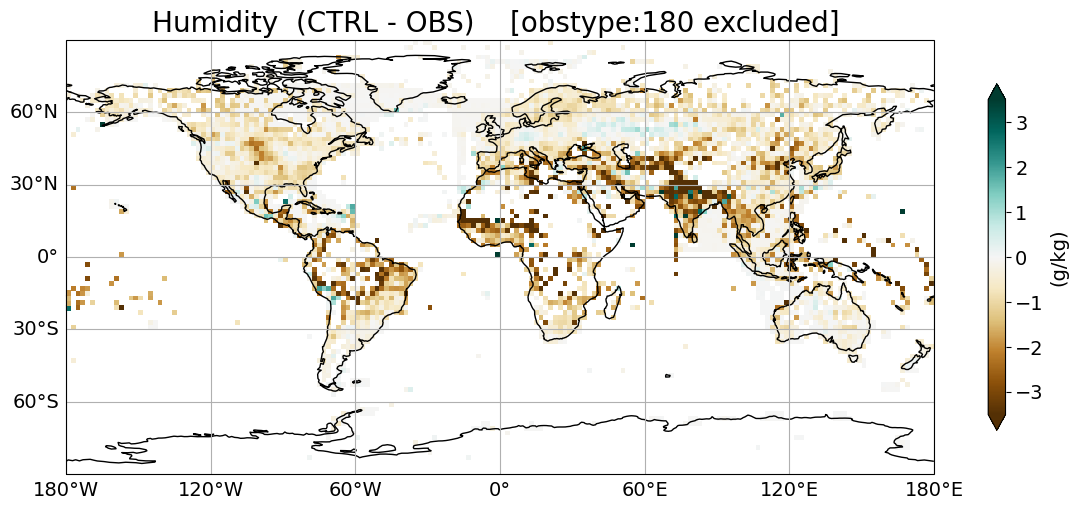

In [18]:
# Plot data distribution (2025/04/03: used to check data distribution for conventional q data)

expref = 'full_CTRL'

save_fig = True
fig_dir = f'/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/python_codes/figures/cnv_meshplot/full_cycled_mode/{expref}'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")


for i in range(1):
    tmp = -meshinfo[expref]['mesh'][i]        # FmO from expref
    tmp[np.where(tmp== 99999.)] = np.nan

    q25 = np.nanquantile(tmp, 0.25)
    q75 = np.nanquantile(tmp, 0.75)
    pltrange = 6*0.5*( np.abs(q25) + np.abs(q75)) 
    
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(14,10))

    ax.coastlines()
    if obs_var == 'q':
        contour = ax.pcolormesh(meshinfo[expref]['lon'], meshinfo[expref]['lat'], tmp*1e3, cmap='BrBG', vmin=-pltrange*1e3, vmax=pltrange*1e3)
    else:
        contour = ax.pcolormesh(meshinfo[expref]['lon'], meshinfo[expref]['lat'], tmp, cmap='RdBu_r', vmin=-pltrange, vmax=pltrange)

    cbar = plt.colorbar(contour, ax=ax, extend='both', orientation='vertical', shrink=0.45) # Adjust the shrink parameter as needed
    cbar.ax.tick_params(labelsize=14)  # Set fontsize for tick labels
    if obs_var == 'q':
        cbar.set_label("(g/kg)", fontsize=14) 
    elif obs_var == 't':
        cbar.set_label("(K)", fontsize=14) 

    
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}
    ax.set_title(rf'{obs_var_long_name}  ({expid_short[expref]} - OBS)    [obstype:180 excluded] ',fontsize=20)

    if save_fig:
        plt.savefig(f'{fig_dir}/cnv_{obs_var}_data_distribution_{expref}_excluding_obstype_180.png', dpi=200, bbox_inches='tight')

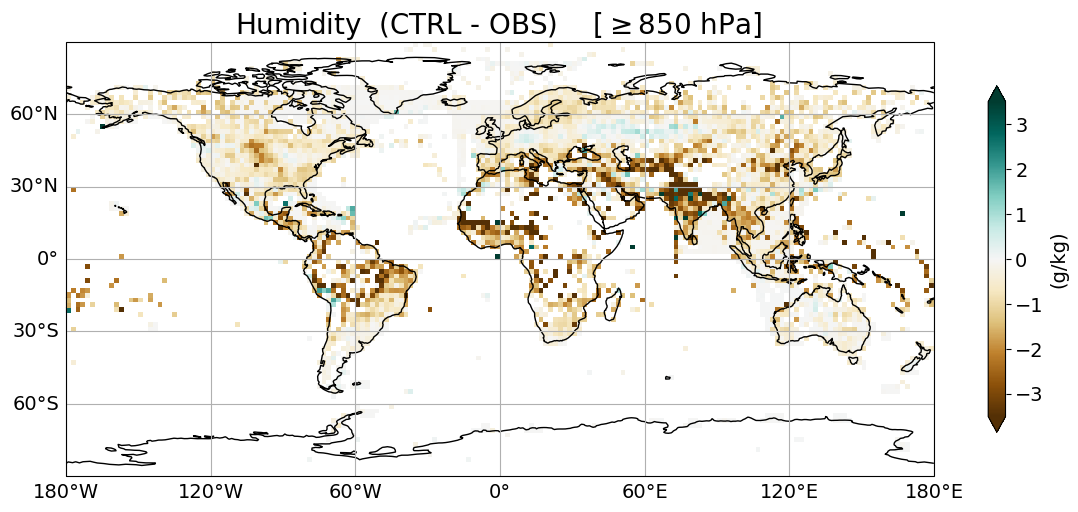

In [10]:
# Plot reference experiemnt's FmO distribution

expref = 'full_CTRL'

save_fig = False
fig_dir = f'/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/python_codes/figures/cnv_meshplot/full_cycled_mode/{expref}'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")


for i in range(1):
#for i in range(len(meshinfo[expref]['levs'])):
    tmp = -meshinfo[expref]['mesh'][i]        # FmO from expref
    tmp[np.where(tmp== 99999.)] = np.nan

    q25 = np.nanquantile(tmp, 0.25)
    q75 = np.nanquantile(tmp, 0.75)
    pltrange = 6*0.5*( np.abs(q25) + np.abs(q75)) 
    
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(14,10))

    ax.coastlines()
    if obs_var == 'q':
        contour = ax.pcolormesh(meshinfo[expref]['lon'], meshinfo[expref]['lat'], tmp*1e3, cmap='BrBG', vmin=-pltrange*1e3, vmax=pltrange*1e3)
    else:
        contour = ax.pcolormesh(meshinfo[expref]['lon'], meshinfo[expref]['lat'], tmp, cmap='RdBu_r', vmin=-pltrange, vmax=pltrange)

    cbar = plt.colorbar(contour, ax=ax, extend='both', orientation='vertical', shrink=0.45) # Adjust the shrink parameter as needed
    cbar.ax.tick_params(labelsize=14)  # Set fontsize for tick labels
    if obs_var == 'q':
        cbar.set_label("(g/kg)", fontsize=14) 
    elif obs_var == 't':
        cbar.set_label("(K)", fontsize=14) 

    
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}
    if i==0:
        lev_bot = 1000
        lev_top = 850
        ax.set_title(rf'{obs_var_long_name}  ({expid_short[expref]} - OBS)    [$\geq$850 hPa] ',fontsize=20)
    else:
        if obs_var == 't':
            lev_bot = pbot[i]
            lev_top = ptop[i]
        elif obs_var == 'q':
            lev_bot = pbotq[i]
            lev_top = ptopq[i]
        elif obs_var == 'gps':
            lev_bot = pbotgps[i]
            lev_top = ptopgps[i]
            
        ax.set_title(f'{obs_var_long_name}   ({expid_short[expref]} - OBS)    [{lev_bot:.0f} - {lev_top:.0f} hPa] ',fontsize=20)

    if save_fig:
        plt.savefig(f'{fig_dir}/cnv_{obs_var}_mesh_fmo_{expref}_{lev_bot}-{lev_top}.png', dpi=200, bbox_inches='tight')

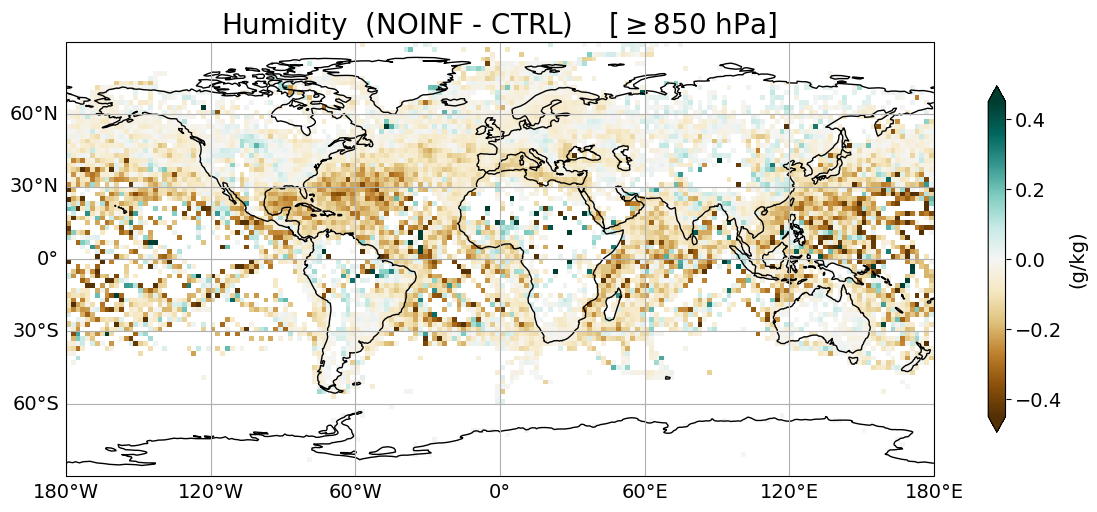

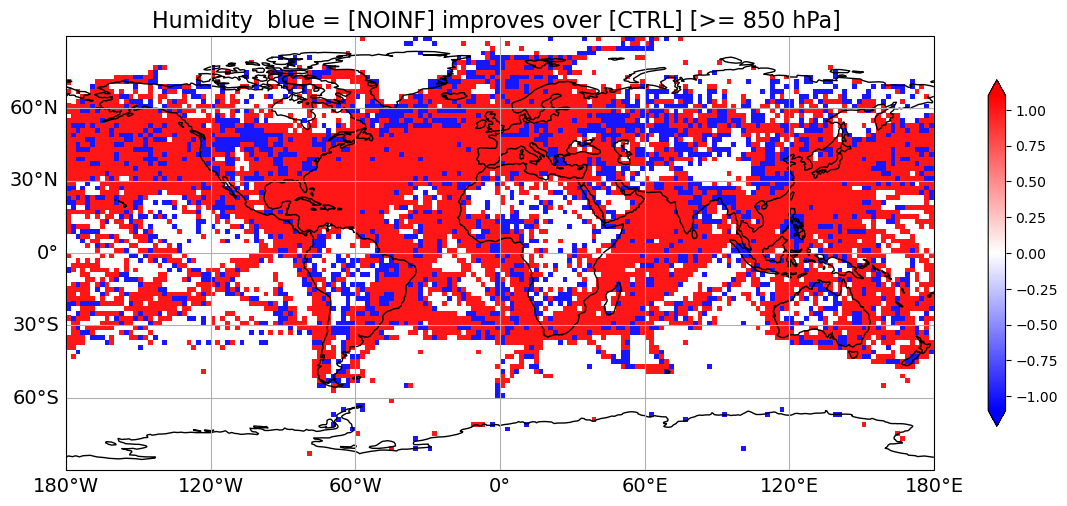

In [52]:
# experiment differences

expref = 'full_CTRL'

save_fig = True

for exp in expids:
    if exp != expref:
        
        fig_dir = f'/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/python_codes/figures/cnv_meshplot/full_cycled_mode/{exp}'

        if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)
            print(f"Directory '{fig_dir}' created.")

        for i in range(1):
        #for i in range(len(meshinfo['levs'])):
            tmp1 = meshinfo[expref]['mesh'][i]        # OmF from expref
            tmp1[np.where(tmp1== -99999.)] = np.nan

            tmp2 = meshinfo[exp]['mesh'][i]           # OmF from the exp
            tmp2[np.where(tmp2== -99999.)] = np.nan

            # the mean OmF(exp1) - OmF(exp2) = exp2 - exp1 
            tmp = tmp1-tmp2
            q25 = np.nanquantile(tmp, 0.25)
            q75 = np.nanquantile(tmp, 0.75)
            #pltrange = 6*0.5*( np.abs(q25) + np.abs(q75)) 
            
            pltrange = 0.45*1e-3

            fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(14,10))

            ax.coastlines()
            if obs_var == 'q':
                contour = ax.pcolormesh(meshinfo[expref]['lon'], meshinfo[expref]['lat'], tmp*1e3, cmap='BrBG', vmin=-pltrange*1e3, vmax=pltrange*1e3)
            else:
                contour = ax.pcolormesh(meshinfo[expref]['lon'], meshinfo[expref]['lat'], tmp, cmap='RdBu_r', vmin=-pltrange, vmax=pltrange)

            cbar = plt.colorbar(contour, ax=ax, extend='both', orientation='vertical', shrink=0.45) # Adjust the shrink parameter as needed
            cbar.ax.tick_params(labelsize=14)  # Set fontsize for tick labels
            if obs_var == 'q':
                cbar.set_label("(g/kg)", fontsize=14) 
            elif obs_var == 't':
                cbar.set_label("(K)", fontsize=14) 
        
            gl = ax.gridlines(draw_labels=True)
            gl.top_labels = False
            gl.right_labels = False
            gl.xformatter = LONGITUDE_FORMATTER
            gl.yformatter = LATITUDE_FORMATTER
            gl.xlabel_style = {'size': 14}
            gl.ylabel_style = {'size': 14}
            if i==0:
                lev_bot = 1000
                lev_top = 850
                ax.set_title(rf'{obs_var_long_name}  ({expid_short[exp]} - {expid_short[expref]})    [$\geq$850 hPa] ',fontsize=20)
            else:
                if obs_var == 't':
                    lev_bot = pbot[i]
                    lev_top = ptop[i]
                elif obs_var == 'q':
                    lev_bot = pbotq[i]
                    lev_top = ptopq[i]
                elif obs_var == 'gps':
                    lev_bot = pbotgps[i]
                    lev_top = ptopgps[i]
                ax.set_title(f'{obs_var_long_name}  mean([{expid_short[exp]}] - [{expid_short[expref]}])    [{lev_bot:.0f} - {lev_top:.0f} hPa] ',fontsize=16)

            if save_fig:
                plt.savefig(f'{fig_dir}/cnv_{obs_var}_mesh_{exp}_minus_{expref}_{lev_bot}-{lev_top}.png', dpi=200, bbox_inches='tight')
                
            plt.show()
            matplotlib.pyplot.close()

            # improve-or-not plot 

            test = -(tmp1-tmp2)*tmp1   # if >0 degrade, <0 improve
            tmp  = test/np.abs(test)
            pltrange = 1.1 

            fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(14,10))

            ax.coastlines()
            contour = ax.pcolormesh(meshinfo[expref]['lon'], meshinfo[expref]['lat'], tmp, cmap='bwr', vmin=-pltrange, vmax=pltrange)

            cbar = plt.colorbar(contour, ax=ax, extend='both', orientation='vertical', shrink=0.45) # Adjust the shrink parameter as needed
            gl = ax.gridlines(draw_labels=True)
            gl.top_labels = False
            gl.right_labels = False
            gl.xformatter = LONGITUDE_FORMATTER
            gl.yformatter = LATITUDE_FORMATTER
            gl.xlabel_style = {'size': 14}
            gl.ylabel_style = {'size': 14}
            if i==0:
                lev_bot = 1000
                lev_top = 850
                ax.set_title(f'{obs_var_long_name}  blue = [{expid_short[exp]}] improves over [{expid_short[expref]}] [>= 850 hPa] ',fontsize=16)
            else:
                if obs_var == 't':
                    lev_bot = pbot[i]
                    lev_top = ptop[i]
                elif obs_var == 'q':
                    lev_bot = pbotq[i]
                    lev_top = ptopq[i]
                elif obs_var == 'gps':
                    lev_bot = pbotgps[i]
                    lev_top = ptopgps[i]

                ax.set_title(f'{obs_var_long_name} blue = [{expid_short[exp]}] improves over [{expid_short[expref]}] [{lev_bot:.0f} - {lev_top:.0f} hPa] ',fontsize=16)

            if save_fig:
                plt.savefig(f'{fig_dir}/improve_plot_{obs_var}_mesh_{exp}_minus_{expref}_{lev_bot}-{lev_top}.png', dpi=200, bbox_inches='tight')
                
            plt.show()
            matplotlib.pyplot.close()

In [ ]:
meshinfo['levs']

In [ ]:
tmp1 = meshinfo['mesh']['CTRL'][3]
tmp1[np.where(tmp1== -99999.)] = np.nan

tmp2 = meshinfo['mesh']['CTRL_no_situ'][3]
tmp2[np.where(tmp2== -99999.)] = np.nan

tmp = tmp2-tmp1

print(np.nanmin(tmp))
print(np.nanmax(tmp))
print(np.nanmean(tmp))